In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [8]:
df = pd.read_excel('C:/Users/ASUS/Desktop/cookie_cats.xlsx')

In [9]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [11]:
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


<Axes: >

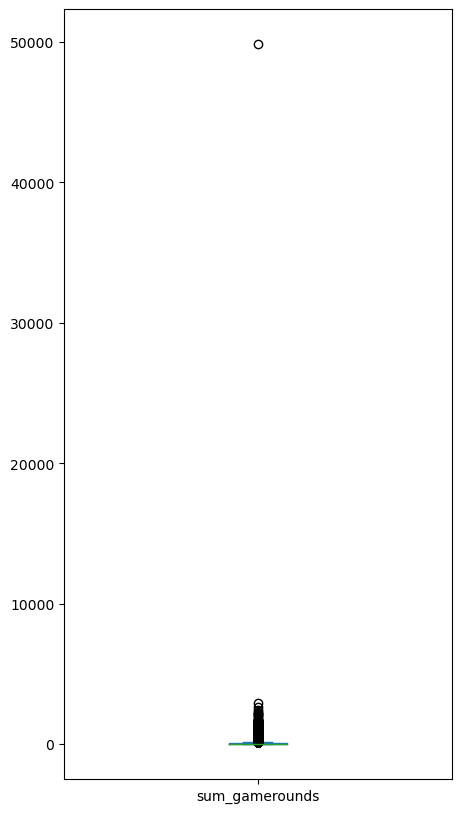

In [13]:
df['sum_gamerounds'].plot.box(figsize=(5,10))

In [14]:
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [17]:
plot_df=df.groupby('sum_gamerounds')['userid'].count()
plot_df

sum_gamerounds
0        3994
1        5538
2        4606
3        3958
4        3629
         ... 
2294        1
2438        1
2640        1
2961        1
49854       1
Name: userid, Length: 942, dtype: int64

Text(0.5, 0, '# Game rounds')

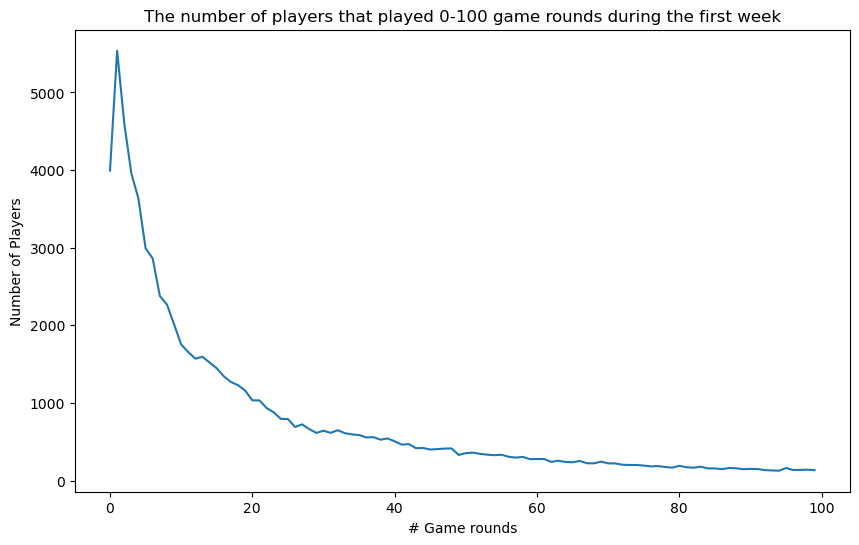

In [18]:
%matplotlib inline

ax = plot_df[:100].plot(figsize=(10,6))
ax.set_title("The number of players that played 0-100 game rounds during the first week")
ax.set_ylabel("Number of Players")
ax.set_xlabel('# Game rounds')

In [19]:
df['retention_1'].sum()/df['retention_1'].count()

0.4452095044850259

In [21]:
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

In [22]:
df.sample(frac=1,replace=True)

,userid,version,sum_gamerounds,retention_1,retention_7
8309,916409,gate_40,8,True,False
84992,9419967,gate_30,4,False,False
49534,5494116,gate_40,4,False,False
28653,3191442,gate_40,14,False,False
75866,8402107,gate_40,5,False,False
...,...,...,...,...,...
6266,693659,gate_30,12,False,False
72810,8064374,gate_40,3,False,False
74622,8268829,gate_40,1,False,False
3936,437151,gate_30,11,False,False


In [23]:
df.sample(frac=1,replace=True).groupby('version')['retention_1'].mean()

version
gate_30    0.444807
gate_40    0.440899
Name: retention_1, dtype: float64

<Axes: ylabel='Density'>

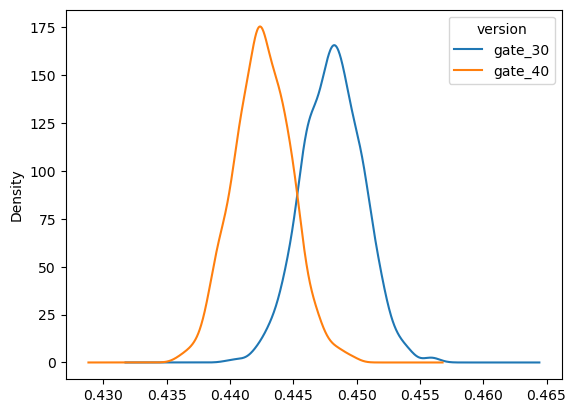

In [26]:
boot_id=[]
for i in range(1000):
    boot_mean=df.sample(frac=1,replace=True).groupby('version')['retention_1'].mean()
    boot_id.append(boot_mean)
boot_id=pd.DataFrame(boot_id)
boot_id.plot(kind='density')

Probability that 1-day retention is greater when the gate is at level 30: 0.95


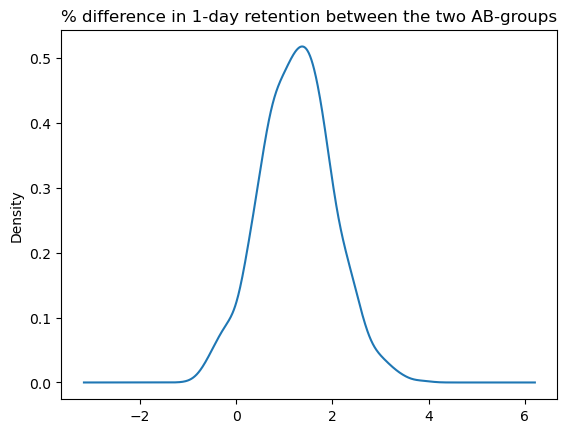

In [28]:
boot_id['diff']=(boot_id.gate_30-boot_id.gate_40)/boot_id.gate_40*100
ax = boot_id['diff'].plot(kind='density')
ax.set_title('% difference in 1-day retention between the two AB-groups')
print('Probability that 1-day retention is greater when the gate is at level 30:',(boot_id['diff'] > 0).mean())

In [31]:
def z_test(p1,p0,n1,n0):
    delta=p1-p0
    p=(p1*n1+p0*n0)/(n1+n0)
    return delta/np.sqrt(p*(1-p)*(1/n1+1/n0))

In [32]:
df[['version','userid','retention_1']].groupby('version').aggregate({'userid':'count','retention_1':'mean'})

,userid,retention_1
version,,
gate_30,44700,0.448188
gate_40,45489,0.442283


In [49]:
retention_30=df[df.version=='gate_30'].retention_1.sum()
n_30=df[df.version=='gate_30'].userid.count()
retention_40=df[df.version=='gate_40'].retention_1.sum()
n_40=df[df.version=='gate_40'].userid.count()
retention_30,n_30,retention_40,n_40

(20034, 44700, 20119, 45489)

In [35]:
p1=retention_30/n_30
n1=n_30
p0=retention_40/n_40
n0=n_40

In [36]:
z_value=z_test(p1,p0,n1,n0)
z_value

1.7840862247974725

In [37]:
from scipy.stats import norm
p_value=1-norm.cdf(z_value)
p_value #p_value小于0.05，null hypothesis为p_30(p1)<=p_40

0.03720482764845956

In [38]:
import statsmodels.api as sm

In [39]:
z_score,p_value=sm.stats.proportions_ztest([retention_30, retention_40], [n_30, n_40], alternative='larger')
z_score,p_value

(1.7840862247974725, 0.03720482764845957)

In [40]:
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

Probability that 7-day retention is greater when the gate is at level 30: 1.0


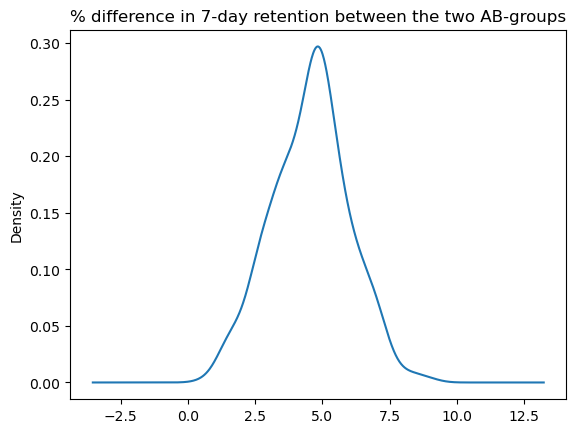

In [41]:
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
boot_7d = pd.DataFrame(boot_7d)
boot_7d['diff'] = (boot_7d.gate_30 - boot_7d.gate_40)/boot_7d.gate_40*100
ax = boot_7d['diff'].plot(kind='density')
ax.set_title('% difference in 7-day retention between the two AB-groups')
print('Probability that 7-day retention is greater when the gate is at level 30:',(boot_7d['diff'] > 0).mean())

In [42]:
df[['version','userid','retention_7']].groupby('version').aggregate({'userid':'count','retention_7':'mean'})

,userid,retention_7
version,,
gate_30,44700,0.190201
gate_40,45489,0.182000


In [43]:
retention_30=df[df.version=='gate_30'].retention_7.sum()
n_30=df[df.version=='gate_30'].userid.count()
retention_40=df[df.version=='gate_40'].retention_7.sum()
n_40=df[df.version=='gate_40'].userid.count()
retention_30,n_30,retention_40,n_40

(8502, 44700, 8279, 45489)

In [44]:
p1=retention_30/n_30
n1=n_30
p0=retention_40/n_40
n0=n_40

In [45]:
z_value=z_test(p1,p0,n1,n0)
z_value

3.164358912748191

In [46]:
from scipy.stats import norm
p_value=1-norm.cdf(z_value)
p_value                        #p_value小于0.05，null hypothesis为p_30(p1)<=p_40

0.0007771249878071318

In [47]:
import statsmodels.api as sm

In [48]:
z_score,p_value=sm.stats.proportions_ztest([retention_30, retention_40], [n_30, n_40], alternative='larger')
z_score,p_value

(3.164358912748191, 0.0007771249878071645)

In [53]:
retention_dic = {'users':{'gate_30':n_30,'gate_40':n_40},'retention': {'gate_30':retention_30,'gate_40':retention_40}}
retention_table = pd.DataFrame(retention_dic)
retention_table['retention %'] = retention_table['retention'] /retention_table['users']
retention_table

,users,retention,retention %
gate_30,44700,20034,0.448188
gate_40,45489,20119,0.442283


In [55]:
df.columns

Index(['userid', 'version', 'sum_gamerounds', 'retention_1', 'retention_7'], dtype='object')

In [56]:
df[['sum_gamerounds','retention_1', 'retention_7']].corr()

,sum_gamerounds,retention_1,retention_7
sum_gamerounds,1.000000,0.197603,0.279288
retention_1,0.197603,1.000000,0.327401
retention_7,0.279288,0.327401,1.000000


<Axes: >

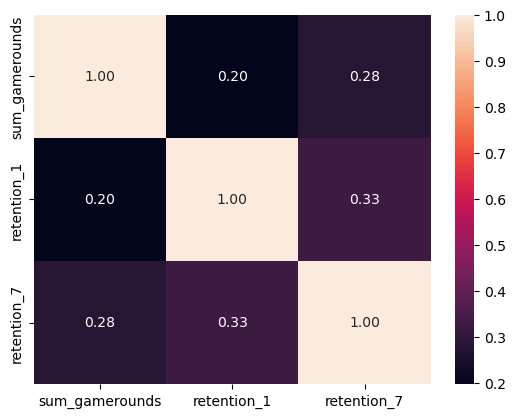

In [60]:
sns.heatmap(df[['sum_gamerounds','retention_1', 'retention_7']].corr(),annot=True,fmt=".2f")